# Assignment 4: Dynamic Programming

Welcome to Assignment 4. This notebook will help you understand:
- Policy Evaluation and Policy Improvement.
- Value and Policy Iteration.
- Bellman Equations.

## Gridworld City

Gridworld City is a metropolis with a growing technology sector that has attracted many data science engineers. However, the city's fixed-rate street parking system is struggling to meet the increased demand. To address this, the city council plans to modify the pricing scheme to enhance social welfare, valuing maximized parking use while ensuring at least one space remains available for urgent needs. To tackle this issue, the council has developed a Markov Decision Process (MDP) to model parking demand and create a reward function reflecting these preferences. Now, the city wants to use dynamic programming to help determine the optimal parking policy.

## Preliminaries
You'll need two imports to complete this assigment:
- numpy: The fundamental package for scientific computing with Python.
- tools: A module containing an environment and a plotting function.

In [ ]:
%matplotlib inline
import numpy as np
import tools

<Figure size 640x480 with 0 Axes>

In the city council's parking MDP, states are nonnegative integers indicating how many parking spaces are occupied, actions are nonnegative integers designating the price of street parking, the reward is a real value describing the city's preference for the situation, and time is discretized by hour. As might be expected, charging a high price is likely to decrease occupancy over the hour, while charging a low price is likely to increase it.

For now, let's consider an environment with four parking spaces and three price points. Note that an environment with four parking spaces actually has five states &mdash; 0, 1, 2, 3 or 4 spaces could be occupied.

In [ ]:
num_spaces = 4
num_prices = 3
env = tools.ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
pi = np.ones((num_spaces + 1, num_prices)) / num_prices

The value function is a one-dimensional array where the $i$-th entry gives the value of $i$ spaces being occupied.

In [ ]:
V

array([0., 0., 0., 0., 0.])

We can represent the policy as a two-dimensional array where the $(i, j)$-th entry gives the probability of taking action $j$ in state $i$.

In [ ]:
pi

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [ ]:
pi[0] = [0.75, 0.11, 0.14]

for s, pi_s in enumerate(pi):
    for a, p in enumerate(pi_s):
        print(f'pi(A={a}|S={s}) = {p.round(2)}    ', end='')
    print()

pi(A=0|S=0) = 0.75    pi(A=1|S=0) = 0.11    pi(A=2|S=0) = 0.14    
pi(A=0|S=1) = 0.33    pi(A=1|S=1) = 0.33    pi(A=2|S=1) = 0.33    
pi(A=0|S=2) = 0.33    pi(A=1|S=2) = 0.33    pi(A=2|S=2) = 0.33    
pi(A=0|S=3) = 0.33    pi(A=1|S=3) = 0.33    pi(A=2|S=3) = 0.33    
pi(A=0|S=4) = 0.33    pi(A=1|S=4) = 0.33    pi(A=2|S=4) = 0.33    


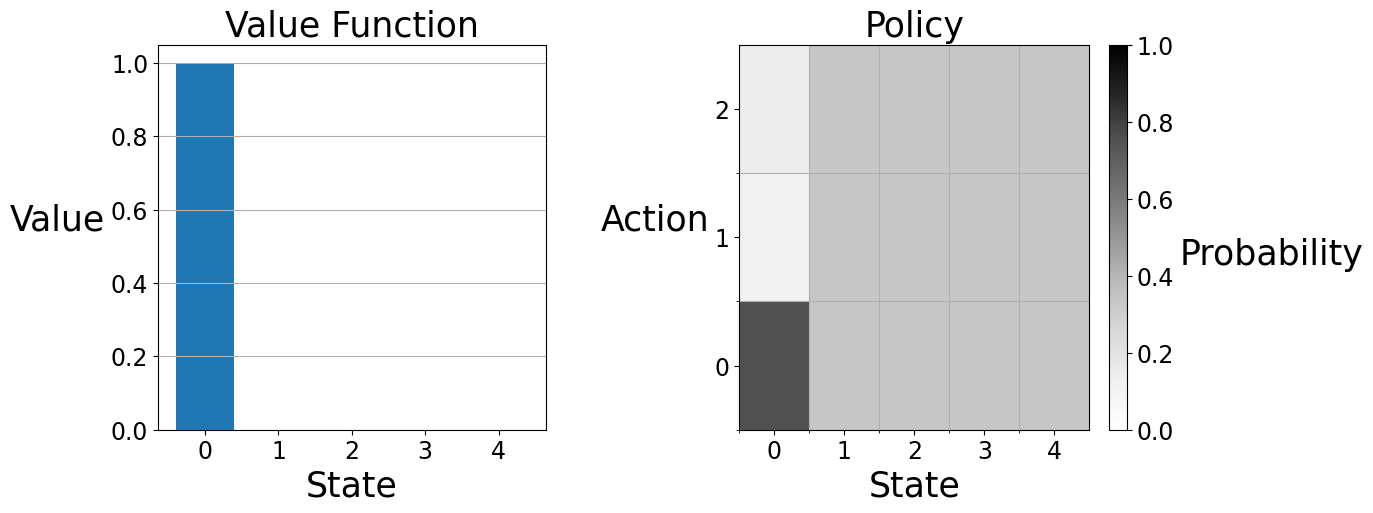

In [ ]:
V[0] = 1

tools.plot(V, pi)

We can visualize a value function and policy with the `plot` function in the `tools` module. On the left, the value function is displayed as a barplot. State zero has an expected return of ten, while the other states have an expected return of zero. On the right, the policy is displayed on a two-dimensional grid. Each vertical strip gives the policy at the labeled state. In state zero, action zero is the darkest because the agent's policy makes this choice with the highest probability. In the other states the agent has the equiprobable policy, so the vertical strips are colored uniformly.

You can access the state space and the action set as attributes of the environment.

In [ ]:
env.S

[0, 1, 2, 3, 4]

In [ ]:
env.A

[0, 1, 2]

You will need to use the environment's `transitions` method to complete this assignment. The method takes a state and an action and returns a 2-dimensional array, where the entry at $(i, 0)$ is the reward for transitioning to state $i$ from the current state and the entry at $(i, 1)$ is the conditional probability of transitioning to state $i$ given the current state and action.

In [ ]:
state = 3
action = 1
transitions = env.transitions(state, action)
transitions

array([[3.        , 0.10016883],
       [4.        , 0.12234648],
       [5.        , 0.14943433],
       [6.        , 0.18010206],
       [4.33333333, 0.4479483 ]])

In [ ]:
for sp, (r, p) in enumerate(transitions):
    print(f'p(S\'={sp}, R={r} | S={state}, A={action}) = {p.round(2)}')

p(S'=0, R=3.0 | S=3, A=1) = 0.1
p(S'=1, R=4.0 | S=3, A=1) = 0.12
p(S'=2, R=5.0 | S=3, A=1) = 0.15
p(S'=3, R=6.0 | S=3, A=1) = 0.18
p(S'=4, R=4.333333333333333 | S=3, A=1) = 0.45


## Section 1: Policy Evaluation

You're now ready to begin the assignment! First, the city council would like you to evaluate the quality of the existing pricing scheme. Policy evaluation works by iteratively applying the Bellman equation for $v_{\pi}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \sum_a \pi(a | s) \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$
This update can either occur "in-place" (i.e. the update rule is sequentially applied to each state) or with "two-arrays" (i.e. the update rule is simultaneously applied to each state). Both versions converge to $v_{\pi}$ but the in-place version usually converges faster. **In this assignment, we will be implementing all update rules in-place**, as is done in the pseudocode of chapter 4 of the textbook.

It is up to you to fill in the policy evaluation function `evaluate_policy` and the `bellman_update` function to complete the algorithm  described in chapter 4.1 of the textbook.

In [ ]:
# ======================================================
# Policy Evaluation with Dynamic Programming
# This function iteratively evaluates a given policy by updating the state-value function V.
# It continues updating until the maximum change in V (delta) falls below a threshold (theta).
# ======================================================

def evaluate_policy(env, V, pi, gamma, theta):

    # Start with a huge delta to ensure the loop begins.
    delta = np.inf
    # Loop until the value function converges (i.e., changes are smaller than theta).
    while delta > theta:
      # Reset the maximum change in V for this sweep over all states.
      delta = 0
      # Iterate over every state in the environment.
      for s in env.S:
        # Store the old value of state s for comparison.
        v_old = V[s]

        # Update the value of state s using the Bellman update rule.
        # This reflects the expected returns following the policy pi.
        V[s] = bellman_update(env, V, pi, s, gamma)

        # Calculate the change for state s and update delta if it's the largest observed.
        # This measures error to see if we need to keep learning.
        delta = max(delta, np.abs(V[s] - v_old))

    # Once the changes are small enough, return the converged value function.
    return V

In [ ]:
# ======================================================
# Bellman Update for Policy Evaluation
# This function updates the state-value function V at a given state s.
# It computes the expected return over all actions and transitions, weighted by the policy probabilities.
# ======================================================

def bellman_update(env, V, pi, s, gamma):

    t1 = 0
    # Iterate over each possible action in the action space.
    for a in env.A:
        # Retrieve the list of transitions for state s given action a.
        # Each transition contains the reward and probability for moving to the next state.
        transitions = env.transitions(s, a)

        # Initialize the sum for the expected return for action a.
        t2 = 0

        # Iterate over each possible next state (sp) and its associated reward and probability.
        for sp, (r, p) in enumerate(transitions):
            # Add the expected return from this transition:
            # probability * (immediate reward + discounted future value)
            t2 += p * (r + gamma * V[sp])

        # Weight the action's expected return by the policy's probability of choosing action a in state s,
        # and accumulate it into t1.
        t1 += pi[s, a] * t2

    # Update the value function for state s with the newly computed expected return.
    return t1

The cell below uses the policy evaluation algorithm to evaluate the city's policy, which charges a constant price of one.

In [ ]:
"""
# Dynamic Programming Test for Parking MDP
# This script sets up a test environment and evaluates the policy using dynamic programming.
"""

# Set up test environment with defined number of parking spaces and price levels
num_spaces = 15  # Number of parking spaces
num_prices = 4   # Number of pricing levels
env = tools.ParkingWorld(num_spaces, num_prices)  # Initialize the environment

# Build a test policy where the parking fee is always set to level 1
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1.0

# Define discount factor and convergence threshold
gamma = 0.9  # Discount factor for future rewards
theta = 0.1  # Convergence threshold for value iteration

# Initialize the value function for all states
V = np.zeros(num_spaces + 1)

# Evaluate the policy using policy evaluation
V = evaluate_policy(env, V, city_policy, gamma, theta)

# Expected value function for validation
answer=[124.42, 126.44, 128.68, 131.02, 133.42, 135.82, 138.2, 140.52, 142.76, 144.86, 146.8, 148.54, 150.00, 151.14, 151.93, 142.29]

# Print the computed value function for verification
print("Computed Value Function:")
print(V)


Computed Value Function:
[124.41727948 126.44283987 128.68019699 131.02413333 133.41736617
 135.82151414 138.20175632 140.52444636 142.75566115 144.86021427
 146.80089257 148.53777788 149.99926103 151.14390889 151.92755887
 142.29253577]


You can use the ``plot`` function to visualize the final value function and policy.

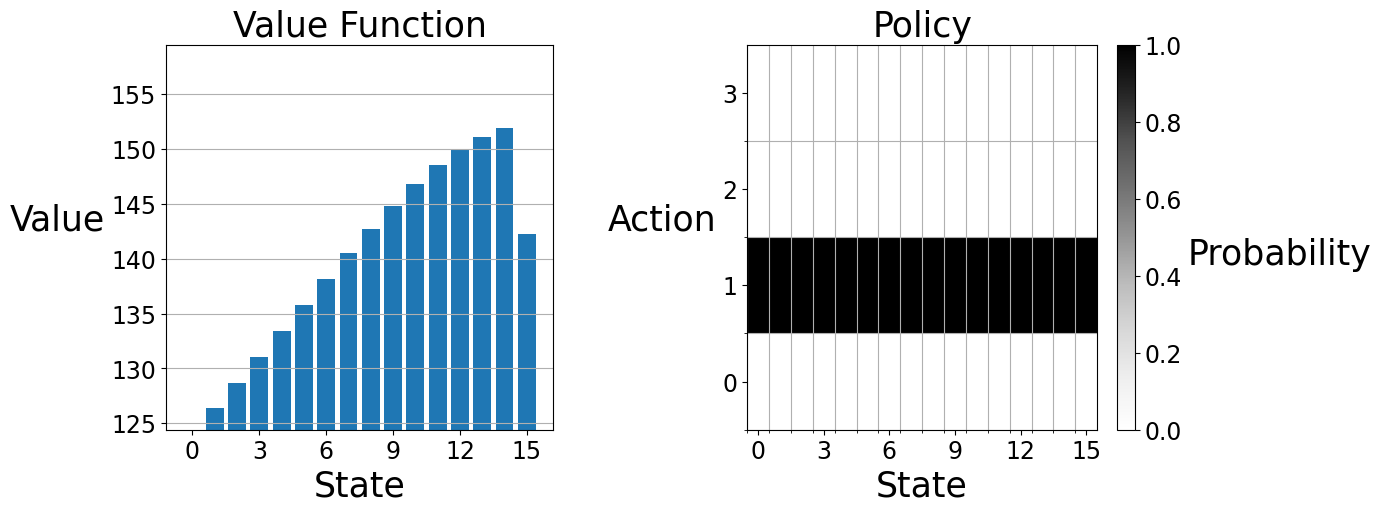

In [ ]:
# Plot the computed value function and policy for visualization
tools.plot(V, city_policy)

**Discuss how does the value function reflect the city council's preferences for parking occupancy?**

The value function reflects the city council’s preference by showing the impact of their fixed pricing policy (always setting the price to level 1).

- More Occupancy, More Value: when the parking is filling up, revenue increases, so the value function rises.

- Fixed Pricing Effect: Since the price never changes, the function captures the expected revenue only.

- No Occupancy Control: With a static price, there is no effort to manage parking demand. A dynamic policy would be needed for better balance.

## Section 2: Policy Iteration
Now the city council would like you to compute a more efficient policy using policy iteration. Policy iteration works by alternating between evaluating the existing policy and making the policy greedy with respect to the existing value function. Fill in the `improve_policy` and `q_greedify_policy` functions, such that the policy is modified at $s$ to be greedy with respect to the q-values at $s$, to complete the policy improvement algorithm.

In [ ]:
# ======================================================
# Policy Improvement: Greedy Update Step
# This function updates the policy to be greedy with respect to the current value function.
# It iterates over each state, adjusts the policy, and checks if any changes were made.
# If any state’s policy changes, the overall policy is marked as unstable (i.e., it can be further improved).
# ======================================================

def improve_policy(env, V, pi, gamma):

    # Assume the current policy is stable until we find a change.
    policy_stable = True

    # Loop over every state in the environment.
    for s in env.S:
        # Copy the current policy for state s to compare later.
        old_pi_s = pi[s].copy()

        # Update the policy at state s to be greedy with respect to the current value function.
        q_greedify_policy(env, V, pi, s, gamma)

        # If the updated policy is different from the old policy, mark as unstable.
        if not np.array_equal(pi[s], old_pi_s):
            policy_stable = False

    # Return the improved policy and a flag indicating whether the policy has converged.
    return pi, policy_stable

In [ ]:
# ======================================================
# Policy Iteration for Optimal Policies with Dynamic Programming
# This function implements the policy iteration algorithm to find the optimal policy.
# It alternates between evaluating the current policy (updating the value function V)
# and improving the policy (making it greedy with respect to V) until the policy converges.
# ======================================================

def policy_iteration(env, gamma, theta):


    # Initialize the value function V to zeros for all states.
    V = np.zeros(len(env.S))
    # Initialize a uniform random policy for all states and actions.
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    # Start with the assumption that the policy is not yet stable.
    policy_stable = False
    # Repeat the evaluation and improvement steps until the policy stops changing.
    while not policy_stable:
        # Evaluate the current policy to update the value function V.
        V = evaluate_policy(env, V, pi, gamma, theta)
        # Improve the policy based on the updated value function.
        pi, policy_stable = improve_policy(env, V, pi, gamma)
    # Return the final value function and the optimal policy.
    return V, pi


In [ ]:
# ======================================================
# Shaping the Policy to Favor High-Value Actions
# This function updates the policy for a given state (s) to be greedy with respect to
# the Q-values derived from the current value function V. It computes the expected
# return for each action and then adjusts the policy to assign equal probability to all
# actions that yield the maximum Q-value.
# ======================================================

def q_greedify_policy(env, V, pi, s, gamma):

    # Initialize an array to store Q-values for each action available in state s.
    Q = np.zeros(len(env.A))
    # Prepare an array to construct the new, greedy policy for state s.
    new_pi_s = np.zeros(len(env.A))
    # Iterate over every possible action.
    for a in env.A:
        # Retrieve the transition details for taking action a in state s.
        # Each element in 'transitions' is a tuple (r, p) for the resulting state.
        transitions = env.transitions(s, a)
        # Compute the Q-value for action a by summing over all possible next states.
        for sp, (r, p) in enumerate(transitions):
            # Add the expected return: probability * (reward + discounted future value)
            Q[a] += p * (r + gamma * V[sp])

        # Store the computed Q-value for action a.


    # Identify the action(s) with the highest Q-value and set their probability to 1.
    best_actions = np.argwhere(Q == np.max(Q)).flatten()
    new_pi_s[best_actions] = 1.0 / len(best_actions)
    # Normalize the new policy distribution so that it sums to 1.


    # Update the policy for state s with the new greedy distribution.
    pi[s] = new_pi_s

In [ ]:
"""
# Policy Iteration for Optimal Parking Strategy
# This script runs policy iteration on the Parking MDP to compute the optimal value function and policy.
"""

# Define discount factor and convergence threshold
gamma = 0.9  # Discount factor for future rewards
theta = 0.1  # Convergence threshold for policy evaluation

# Initialize the Parking MDP environment with 10 spaces and 4 pricing levels
env = tools.ParkingWorld(num_spaces=15, num_prices=4)

# Perform policy iteration to compute the optimal value function and policy
V, pi = policy_iteration(env, gamma, theta)

# Expected results for verification
V_answer = [128.85, 130.96, 133.22, 135.56, 137.94, 140.32, 142.67, 144.94, 147.1, 149.11, 150.93, 152.54, 153.88, 154.95, 155.98, 146.71]  # Expected value function
pi_answer = [  # Expected optimal policy
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
]

# Print the expected value function for validation
print("Expected Value Function:")
print(V)

# Print the expected optimal policy for verification
print("\nExpected Optimal Policy:")
print(pi)

Expected Value Function:
[128.85388152 130.96340048 133.21772383 135.55790789 137.939144
 140.32344284 142.67273558 144.94191449 147.09825463 149.1076519
 150.93399902 152.53860101 153.87955828 154.95222212 155.97823227
 146.7105501 ]

Expected Optimal Policy:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


When you are ready to test the policy iteration algorithm, run the cell below.

In [ ]:
env = tools.ParkingWorld(num_spaces=15, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)

You can use the ``plot`` function to visualize the final value function and policy.

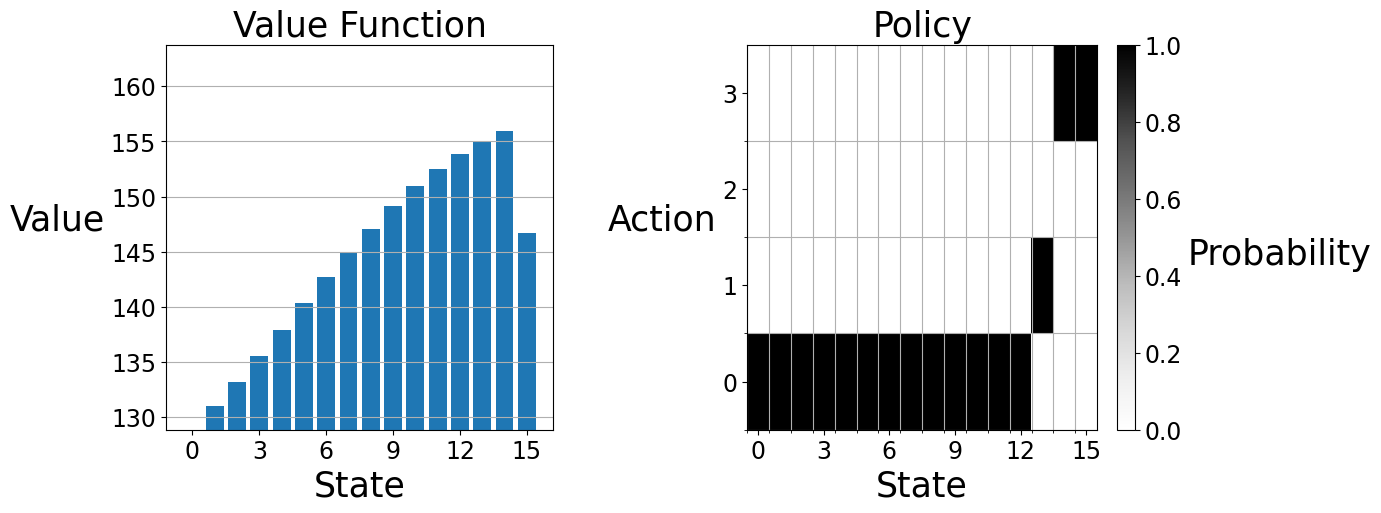

In [ ]:
tools.plot(V, pi)

In [ ]:
V

array([128.85388152, 130.96340048, 133.21772383, 135.55790789,
       137.939144  , 140.32344284, 142.67273558, 144.94191449,
       147.09825463, 149.1076519 , 150.93399902, 152.53860101,
       153.87955828, 154.95222212, 155.97823227, 146.7105501 ])

You can check the value function (rounded to one decimal place) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        81.6 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        83.3 $\quad\quad\;$ 0<br>
2 $\quad\quad\quad\;$        85.0 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        86.8 $\quad\quad\;$ 0<br>
4 $\quad\quad\quad\;$        88.5 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        90.2 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        91.7 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        93.1 $\quad\quad\;$ 0<br>
8 $\quad\quad\quad\;$        94.3 $\quad\quad\;$ 0<br>
9 $\quad\quad\quad\;$        95.3 $\quad\quad\;$ 3<br>
10 $\quad\quad\;\;\,\,$      89.5 $\quad\quad\;$ 3<br>

## Section 3: Value Iteration
The city has also heard about value iteration and would like you to implement it. Value iteration works by iteratively applying the Bellman optimality equation for $v_{\ast}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \max_a \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$
Fill in the `value_iteration` and `bellman_optimality_update` functions described in chapter 4.4 of the textbook to complete the value iteration algorithm.

In [ ]:
# ======================================================
# Value Iteration: Optimizing Your Policy with Dynamic Programming
# This function implements the value iteration algorithm to compute the optimal value function (V)
# and the corresponding greedy policy (pi). It repeatedly updates V using the Bellman optimality
# equation until convergence (i.e., when the maximum change in V is less than theta), and then it
# extracts the optimal policy by making it greedy with respect to the updated V.
# ======================================================

def value_iteration(env, gamma, theta):

    # Initialize the value function V to zero for all states.
    V = np.zeros(len(env.S))

    # Iteratively update V until the maximum change (delta) falls below the threshold theta.
    while True:  # Start with an infinite loop, break when convergence is achieved
        # Reset the maximum change for this iteration.
        delta = 0

        # Iterate over each state in the environment
        for s in env.S:
            # Save the current value of state s for comparison.
            v = V[s]

            # Update V[s] using the Bellman optimality equation.
            V[s] = bellman_optimality_update(env, V, s, gamma)

            # Update delta with the maximum change observed across states.
            delta = max(delta, np.abs(V[s] - v))

        # If the value function has converged, exit the loop.
        if delta < theta:
            break

    # Initialize a uniform policy over all actions for all states.
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)

    # Refine the policy by making it greedy with respect to the final value function V.
    for s in env.S:
        q_greedify_policy(env, V, pi, s, gamma)

    # Return the optimal value function and the corresponding greedy policy.
    return V, pi

In [ ]:
# ======================================================
# Bellman Optimality Update for Value Iteration
# This function updates the value function V at a given state s using the Bellman
# optimality equation. It computes the expected return (Q-value) for each action by
# considering all possible transitions, and then updates V[s] to be the maximum Q-value.
# ======================================================

def bellman_optimality_update(env, V, s, gamma):

    # Initialize an array to store the Q-value for each action in state s.
    Q = np.zeros(len(env.A))

    # Iterate over every action available in state s.
    for a in env.A:
        # Retrieve all transitions for action a in state s.
        # Each transition is a tuple (r, p) where:
        #   r = immediate reward,
        #   p = probability of that transition.
        transitions = env.transitions(s, a)

        # Sum over all transitions to compute the Q-value for action a.
        for sp, (r, p) in enumerate(transitions):
            # Add the expected return: probability * (reward + discounted future value)
            Q[a] += p * (r + gamma * V[sp])

        # Store the computed Q-value for action a.

    # Update the value function for state s to be the maximum Q-value over all actions.
    return np.max(Q) # Return the maximum Q-value

In [ ]:
"""
# Value Iteration for Parking MDP
# This script performs value iteration using the Bellman optimality update to compute the optimal value function.
"""

# Define discount factor
gamma = 0.9  # Discount factor for future rewards

# Initialize the Parking MDP environment with 10 spaces and 4 pricing levels
env = tools.ParkingWorld(num_spaces=15, num_prices=4)

# Initialize the value function with arbitrary values
V = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

# Perform value iteration using the Bellman optimality update
# Iterate multiple times to converge to the optimal value function
for _ in range(10):  # Repeat for convergence
    for s in env.S:  # Update value for each state
        V[s] = bellman_optimality_update(env, V, s, gamma)  # Apply Bellman update

# Expected result for verification
answer = [97, 100, 103, 105, 108, 111, 113, 116, 118, 120, 122, 124, 126, 127, 128, 119]  # Expected value function

# Print the computed value function for validation
print("Computed Value Function:")
print(V)

Computed Value Function:
[ 97 100 103 105 108 111 113 116 118 120 122 124 126 127 128 119]


When you are ready to test the value iteration algorithm, run the cell below.

In [ ]:
env = tools.ParkingWorld(num_spaces=15, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration(env, gamma, theta)

You can use the ``plot`` function to visualize the final value function and policy.

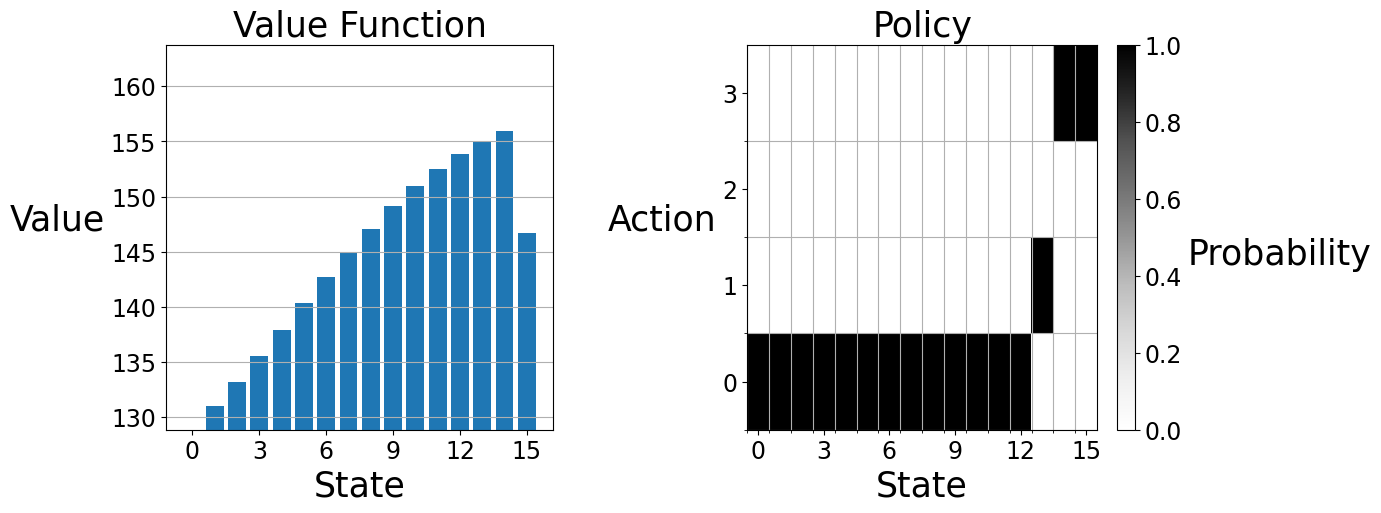

In [ ]:
tools.plot(V, pi)

In [ ]:
V

array([128.85081235, 130.96039224, 133.21476581, 135.55499286,
       137.93626679, 140.32059965, 142.66992416, 144.93913244,
       147.09549999, 149.10492299, 150.9312944 , 152.53591939,
       153.8768985 , 154.94959206, 155.97564426, 146.70798062])

You can check your value function (rounded to one decimal place) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        81.6 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        83.3 $\quad\quad\;$ 0<br>
2 $\quad\quad\quad\;$        85.0 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        86.8 $\quad\quad\;$ 0<br>
4 $\quad\quad\quad\;$        88.5 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        90.2 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        91.7 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        93.1 $\quad\quad\;$ 0<br>
8 $\quad\quad\quad\;$        94.3 $\quad\quad\;$ 0<br>
9 $\quad\quad\quad\;$        95.3 $\quad\quad\;$ 3<br>
10 $\quad\quad\;\;\,\,$      89.5 $\quad\quad\;$ 3<br>

In the value iteration algorithm above, a policy is not explicitly maintained until the value function has converged. Below, we have written an identically behaving value iteration algorithm that maintains an updated policy. Writing value iteration in this form makes its relationship to policy iteration more evident. Policy iteration alternates between doing complete greedifications and complete evaluations. On the other hand, value iteration alternates between doing local greedifications and local evaluations.

In [ ]:
# ======================================================
# Value Iteration Variant with Simultaneous Policy Update
# This function implements a twist on the standard value iteration algorithm.
# It updates both the value function V and the policy pi in a single loop.
# For each state, it first makes the policy greedy with respect to the current Q-values
# (computed from V) and then updates V using the Bellman update rule. The process continues
# until the maximum change in V is smaller than the threshold theta.
# ======================================================

def value_iteration2(env, gamma, theta):


    # Initialize the value function V to zero for all states.
    V = np.zeros(len(env.S))

    # Initialize the policy pi to be uniform over all available actions for each state.
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)

    # Loop until the value function converges (i.e., changes become negligible).
    while True:
        # Reset the maximum change in V for this iteration.
        delta = 0

        # Process each state in the environment.
        for s in env.S:
            # Store the current value for state s to later measure the change.
            v = V[s]

            # Update the policy for state s to be greedy with respect to the Q-values derived from V.
            q_greedify_policy(env, V, pi, s, gamma)

            # Update the value function V for state s using the Bellman update rule.
            V[s] = bellman_update(env, V, pi, s, gamma)

            # Track the maximum change observed in the value function.
            delta = max(delta, np.abs(V[s] - v))

        # If the largest change is less than the threshold theta, convergence is achieved.
        if delta < theta:
            break

    # Return the final value function and the corresponding greedy policy.
    return V, pi

You can try the second value iteration algorithm by running the cell below.

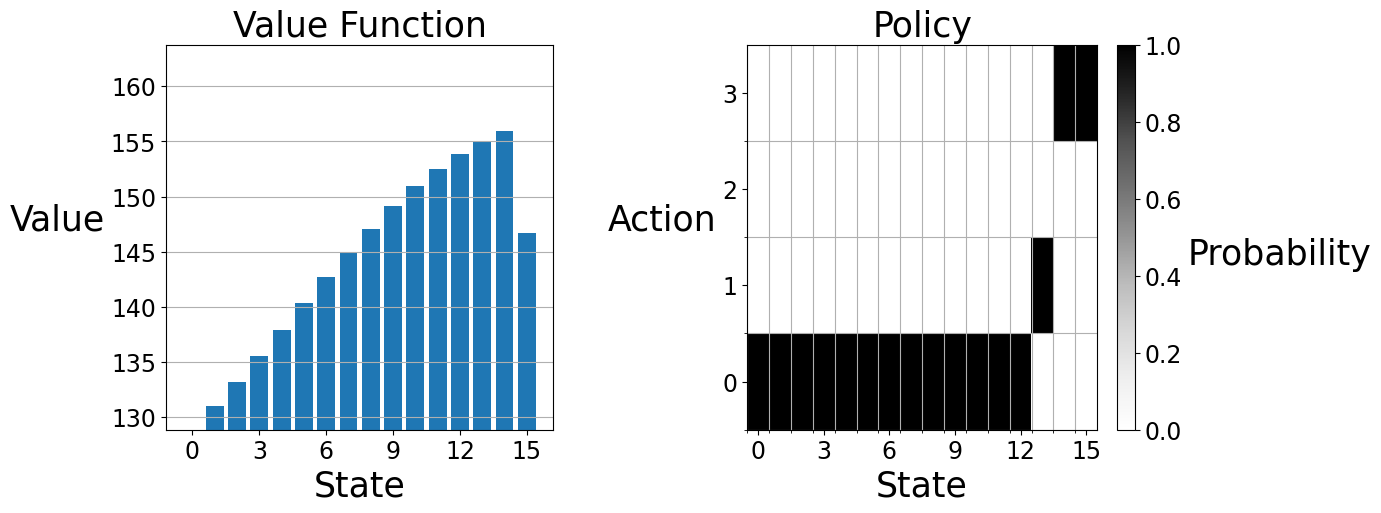

In [ ]:
env = tools.ParkingWorld(num_spaces=15, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration2(env, gamma, theta)
tools.plot(V, pi)

In [ ]:
V

array([128.85081235, 130.96039224, 133.21476581, 135.55499286,
       137.93626679, 140.32059965, 142.66992416, 144.93913244,
       147.09549999, 149.10492299, 150.9312944 , 152.53591939,
       153.8768985 , 154.94959206, 155.97564426, 146.70798062])

## Conclusion
Congratulations, you've completed assignment 4! In this assignment, we investigated policy evaluation and policy improvement, policy iteration and value iteration, and Bellman updates. Gridworld City thanks you for your service!